In [1]:
# heh get it

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from scipy import signal, optimize, stats

openloop = np.load('keck_tt/OpenLoop_n0088.npy')
centroid_loaded = np.load('keck_tt/Centroid_n0088.npy')
centroid_recovered = np.zeros(centroid_loaded.shape)
commands_loaded = np.load('keck_tt/Commands_n0088.npy')
commands = np.zeros(commands_loaded.shape) # to check later if this matches keck_tt/Commands

steps = openloop.shape[0]
f_sampling = 1000
times = np.arange(0, steps/f_sampling, 1/f_sampling)

In [2]:
for i in range(steps):
    if i < 3:
        commands[i] = 0.1*centroid_loaded[i]
    else:
        commands[i] = 0.6*commands[i-1] + 0.32*commands[i-2] + 0.08*commands[i-3] + 0.1*centroid_recovered[i]
    centroid_recovered[i] = openloop[i] + commands[i]

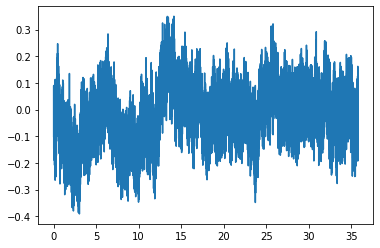

In [3]:
plt.plot(times, (centroid_recovered[:,0] - centroid_loaded[:,0])[:-1])